In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy
from scipy import stats,interpolate
from scipy.stats import skew,kurtosis,describe,variation,shapiro,levene,f_oneway
from scipy.special import kl_div
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import warnings 
warnings.filterwarnings(action='ignore')

import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn import model_selection
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,IsolationForest,StackingClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,fbeta_score,roc_auc_score,classification_report,make_scorer,balanced_accuracy_score
from mlxtend.classifier import StackingClassifier,StackingCVClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler,Binarizer

from imblearn.over_sampling import SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.under_sampling import RandomUnderSampler,NearMiss,TomekLinks,CondensedNearestNeighbour,EditedNearestNeighbours

import random
import tensorflow 
import tensorflow as tf

random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def describex(data):
        data = pd.DataFrame(data)
        stats = data.describe()
        skewness = data.skew()
        kurtosis = data.kurtosis()
        skewness_df = pd.DataFrame({'skewness':skewness}).T
        kurtosis_df = pd.DataFrame({'kurtosis':kurtosis}).T
        Appended_Stats = pd.concat([stats,skewness_df,kurtosis_df],axis=0)
        return Appended_Stats

In [3]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    f1 = f1_score(y_test,pred)
    f2 = fbeta_score(y_test,pred,beta=2)
    balanced_acc = balanced_accuracy_score(y_test,pred)
    print('Confusion Matrix')
    print(confusion)
    print('\n')
    print('정확도:',accuracy.round(3),'정밀도:', precision.round(3),'재현율:',recall.round(3),'AUC:',roc_auc.round(3),'F1:',f1.round(3),'F2:',f2.round(3),'Balanced_Accuracy:',balanced_acc.round(3))

In [4]:
data1 = pd.read_csv('train_input_스핀들전력.csv',encoding='cp949')
data2 = pd.read_csv('train_input_스핀들진동.csv',encoding='cp949')
data3 = pd.read_csv('train_input_전체전력.csv',encoding='cp949')
data4 = pd.read_csv('train_output.csv',encoding='cp949')

In [5]:
for col in data1.columns:
    data1.rename(columns={col:col.replace("s"," ")},inplace=True)
data1.columns = 'SpindlePower_' + data1.columns.astype(str)

for col in data2.columns:
    data2.rename(columns={col:col.replace("s"," ")},inplace=True)
data2.columns = 'SpindleVibration_' + data2.columns.astype(str)

for col in data3.columns:
    data3.rename(columns={col:col.replace("s"," ")},inplace=True)
data3.columns = 'SpindleComprehensive_' + data3.columns.astype(str)

In [6]:
data_full = pd.concat([data1,data2,data3,data4],axis=1)

In [7]:
data_full.shape

(410, 182)

In [8]:
Feature_Selection = True

In [9]:
def Train_Test_Split(Feature_Selection):
    
    Data = data_full
    Input_Data = data_full.drop(['Tool','condition'],axis=1)
    
    X = Input_Data
    y = Data['condition']
    
    if Feature_Selection == False:

        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2021)
        
        ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
        X_test,y_test = ros_test.fit_resample(X_test,y_test)    

        return X_train, y_train, X_test, y_test
    
    if Feature_Selection == True:
        
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2021)
        Train = pd.concat([X_train,y_train],axis=1)
        Pass = Train[Train['condition']==0].drop(['condition'],axis=1)
        Fail = Train[Train['condition']==1].drop(['condition'],axis=1)

        T_Test = stats.ttest_ind(Pass,Fail,equal_var=False) # equal_var=True
        Columns = pd.DataFrame(X_train.columns).rename(columns={0:'Columns'})
        P_Value = pd.DataFrame(T_Test[1]).rename(columns={0:'P-Value'})
        Concat_columns_pvalues = pd.concat([Columns,P_Value],axis=1).dropna()

        Significant_Values = Concat_columns_pvalues[Concat_columns_pvalues['P-Value'] < 0.05]['Columns'].to_list()
        df_ttest = Data[Significant_Values]

        X_train,X_test,y_train,y_test = train_test_split(df_ttest,y,test_size=0.1,random_state=2021)
        
        ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
        X_test,y_test = ros_test.fit_resample(X_test,y_test)    

        return X_train, y_train, X_test, y_test 
    
X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
X_train.shape, X_test.shape

((369, 61), (38, 61))

In [10]:
#### Corr Feature Selection

Data = data_full
Input_Data = data_full.drop(['Tool','condition'],axis=1)

X = Input_Data
y = Data['condition']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2021)
Train = pd.concat([X_train,y_train],axis=1)

df_corr = Train.corr().iloc[1:,-1]
df_corr = pd.DataFrame(df_corr).rename(columns={'condition':'Corr'}).abs().reset_index()
df_corr = df_corr.sort_values(by='Corr',ascending = False).iloc[1:]
df_corr = df_corr[df_corr['Corr'] >= 0.2] # 데이터마다 상관계수 최소값 다름 
Corr_Values = df_corr['index'].to_list()

df_Corr = Data[Corr_Values]
#X_train,X_test,y_train,y_test = train_test_split(df_Corr,y,test_size=0.1,random_state=2021)

#ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
#X_test,y_test = ros_test.fit_resample(X_test,y_test)    

In [11]:
#### VIF Feature Selection

Data = data_full
Input_Data = data_full.drop(['Tool','condition'],axis=1)

X = Input_Data
y = Data['condition']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2021)
Train = pd.concat([X_train,y_train],axis=1)

X = Train.drop(['condition'],axis=1)
scaler = StandardScaler()
scale_cols =  X.columns
scaled_X = scaler.fit_transform(X[scale_cols])
scaled_X = pd.DataFrame(scaled_X, columns=scale_cols)
scaled_X = scaled_X.set_index(X.index)

vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(scaled_X.values, i) 
                     for i in range(scaled_X.shape[1])]
X_Columns = pd.DataFrame(scaled_X.columns).rename(columns={0:'Columns'})

df_vif = pd.concat([X_Columns,vif],axis=1)
df_VIF = Data[df_vif[df_vif['VIF_Factor'] <= 10]['Columns'].to_list()]

#X_train,X_test,y_train,y_test = train_test_split(df_VIF,y,test_size=0.1,random_state=2021)

#ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
#X_test,y_test = ros_test.fit_resample(X_test,y_test)    

In [12]:
# 활용할 ML 나열 
rf = RandomForestClassifier(random_state=2021)
rf_bal = RandomForestClassifier(random_state=2021,class_weight='balanced')
ada = AdaBoostClassifier(random_state=2021)
gbm = GradientBoostingClassifier(random_state=2021)
xgb = XGBClassifier(random_state=2021)
xgb_bal = XGBClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
lgbm =  LGBMClassifier(random_state=2021)
lgbm_bal = LGBMClassifier(random_state=2021,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]) 

models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [13]:
def test_model(model):
        
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    
    ml = model
    ml.fit(X_train,y_train)      
    pred = ml.predict(X_test)
    pred_proba = ml.predict_proba(X_test)[:,1]
    print('----------------------------------------------------------------------------------------------------------')
    get_clf_eval(y_test,pred,pred_proba)  
    print('\n')
    print(classification_report(y_test, pred,target_names=['양품','불량']))
    
    if model == rf:
        print('RandomForest Prediction Result')
        print('\n')
        
    elif model == rf_bal:
        print('RandomForest(Balanced Weight) Prediction Result')
        print('\n')  
        
    elif model == ada:
        print('AdaBoost Prediction Result')
        print('\n')
     
    elif model == gbm:
        print('GradientBoostingMachine Prediction Result')
        print('\n')
        
    elif model == xgb:
        print('XGBoost Prediction Result')
        print('\n')
        
    elif model == xgb_bal:
        print('XGBoost(Balanced Weight) Prediction Result')
        print('\n')    
        
    elif model == lgbm:
        print('LightGBM Prediction')
        print('\n')   
        
    elif model == lgbm_bal:
        print('LightGBM(Balanced Weight) Prediction Result')

In [14]:
test_model(models[7])

----------------------------------------------------------------------------------------------------------
Confusion Matrix
[[17  4]
 [ 3 14]]


정확도: 0.816 정밀도: 0.778 재현율: 0.824 AUC: 0.877 F1: 0.8 F2: 0.814 Balanced_Accuracy: 0.817


              precision    recall  f1-score   support

          양품       0.85      0.81      0.83        21
          불량       0.78      0.82      0.80        17

    accuracy                           0.82        38
   macro avg       0.81      0.82      0.81        38
weighted avg       0.82      0.82      0.82        38

LightGBM(Balanced Weight) Prediction Result


In [15]:
# 전체 모델  원큐 출력 
#for i in range(0,len(models)):

#    model = models[i]
#    test_model(model) # Input_Data, df_ttest, df_L1Penalty

In [16]:
def Oversampling_Test(model):
    
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)

    for i in list(np.arange(0.65,1.05,0.05).round(2)): # sampling_strategy = 0.65, 0.7 , 0.75, 0.8 ,0.85, 0.9, 0.95, 1.0
        oversampler = SMOTEENN(sampling_strategy=i,random_state=2021)
        X_train_over,y_train_over = oversampler.fit_resample(X_train,y_train)
        ml = model
        ml.fit(X_train_over,y_train_over) 
        pred = ml.predict(X_test)
        pred_proba = ml.predict_proba(X_test)[:,1]
        get_clf_eval(y_test,pred,pred_proba)  
        print('\n')
        print(classification_report(y_test, pred,target_names=['양품','불량']))
        
        if model == rf:
            print('RandomForest SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == rf_bal:
            print('RandomForest(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    

        elif model == ada:
            print('AdaBoost SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == gbm:
            print('GradientBoostingMachine SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == xgb:
            print('XGBoost SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == xgb_bal:
            print('XGBoost(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    


        elif model == lgbm:
            print('LightGBM SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   
            
        elif model == lgbm_bal:
            print('LightGBM(Balanced Weight) SMOTEENN'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')          
            
models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [17]:
#Oversampling_Test(models[0])

In [18]:
#Oversampling_Test(models[1])

In [19]:
#Oversampling_Test(models[2])

In [20]:
#Oversampling_Test(models[3])

In [21]:
#Oversampling_Test(models[4])

In [22]:
#Oversampling_Test(models[5])

In [23]:
#Oversampling_Test(models[6])

In [24]:
#Oversampling_Test(models[7])

In [25]:
def Undersampling_Test(model):
     
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)

    for i in list(np.arange(0.65,1.05,0.05).round(2)): # sampling_strategy = 0.65, 0.7 , 0.75, 0.8 ,0.85, 0.9, 0.95, 1.0
        undersampler = RandomUnderSampler(sampling_strategy=i,random_state=2021) 
        #undersampler = NearMiss() --> ROS 이외의 언더샘플링 진행시 for 반복문 해제 
        #  TomekLink(), NeariMss, EditedNearestNeigbours,CondensedNearestNeighbour
        
        X_train_under,y_train_under = undersampler.fit_resample(X_train,y_train)
        ml = model
        ml.fit(X_train_under,y_train_under) 
        pred = ml.predict(X_test)
        pred_proba = ml.predict_proba(X_test)[:,1]
        get_clf_eval(y_test,pred,pred_proba)  
        print('\n')
        print(classification_report(y_test, pred,target_names=['양품','불량']))
        
        if model == rf:
            print('RandomForest ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == rf_bal:
            print('RandomForest(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    

        elif model == ada:
            print('AdaBoost ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == gbm:
            print('GradientBoostingMachine ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')

        elif model == xgb:
            print('XGBoost ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')
            
        elif model == xgb_bal:
            print('XGBoost(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')    


        elif model == lgbm:
            print('LightGBM ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')   
            
        elif model == lgbm_bal:
            print('LightGBM(Balanced Weight) ROS'+'='+str(i),'Prediction Result')
            print('------------------------------------------------------------------------------------------------------')
            print('\n')          
            
models = [rf,rf_bal,ada,gbm,xgb,xgb_bal,lgbm,lgbm_bal]

In [26]:
#Undersampling_Test(models[0])

In [27]:
#Undersampling_Test(models[1])

In [28]:
#Undersampling_Test(models[2])

In [29]:
#Undersampling_Test(models[3])

In [30]:
Undersampling_Test(models[4])

Confusion Matrix
[[18  3]
 [ 4 13]]


정확도: 0.816 정밀도: 0.812 재현율: 0.765 AUC: 0.919 F1: 0.788 F2: 0.774 Balanced_Accuracy: 0.811


              precision    recall  f1-score   support

          양품       0.82      0.86      0.84        21
          불량       0.81      0.76      0.79        17

    accuracy                           0.82        38
   macro avg       0.82      0.81      0.81        38
weighted avg       0.82      0.82      0.82        38

XGBoost ROS=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[18  3]
 [ 3 14]]


정확도: 0.842 정밀도: 0.824 재현율: 0.824 AUC: 0.902 F1: 0.824 F2: 0.824 Balanced_Accuracy: 0.84


              precision    recall  f1-score   support

          양품       0.86      0.86      0.86        21
          불량       0.82      0.82      0.82        17

    accuracy                           0.84        38
   macro avg       0.84      0.84      0.84        38
weig

In [31]:
Undersampling_Test(models[5])

Confusion Matrix
[[17  4]
 [ 2 15]]


정확도: 0.842 정밀도: 0.789 재현율: 0.882 AUC: 0.896 F1: 0.833 F2: 0.862 Balanced_Accuracy: 0.846


              precision    recall  f1-score   support

          양품       0.89      0.81      0.85        21
          불량       0.79      0.88      0.83        17

    accuracy                           0.84        38
   macro avg       0.84      0.85      0.84        38
weighted avg       0.85      0.84      0.84        38

XGBoost(Balanced Weight) ROS=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[14  7]
 [ 1 16]]


정확도: 0.789 정밀도: 0.696 재현율: 0.941 AUC: 0.933 F1: 0.8 F2: 0.879 Balanced_Accuracy: 0.804


              precision    recall  f1-score   support

          양품       0.93      0.67      0.78        21
          불량       0.70      0.94      0.80        17

    accuracy                           0.79        38
   macro avg       0.81      0.80      0.7

In [32]:
#Undersampling_Test(models[6])

In [33]:
Undersampling_Test(models[6])

Confusion Matrix
[[16  5]
 [ 2 15]]


정확도: 0.816 정밀도: 0.75 재현율: 0.882 AUC: 0.919 F1: 0.811 F2: 0.852 Balanced_Accuracy: 0.822


              precision    recall  f1-score   support

          양품       0.89      0.76      0.82        21
          불량       0.75      0.88      0.81        17

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.82        38
weighted avg       0.83      0.82      0.82        38

LightGBM ROS=0.65 Prediction Result
------------------------------------------------------------------------------------------------------


Confusion Matrix
[[16  5]
 [ 2 15]]


정확도: 0.816 정밀도: 0.75 재현율: 0.882 AUC: 0.899 F1: 0.811 F2: 0.852 Balanced_Accuracy: 0.822


              precision    recall  f1-score   support

          양품       0.89      0.76      0.82        21
          불량       0.75      0.88      0.81        17

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.82        38
weig

In [34]:
#Undersampling_Test(models[7])

In [35]:
def preprocessing():
    
    X_train, y_train, X_test, y_test = Train_Test_Split(Feature_Selection)
    undersampler = RandomUnderSampler(sampling_strategy=1.0,random_state=2021) 
    X_train,y_train = undersampler.fit_resample(X_train,y_train)
    
    Train_All = pd.concat([X_train,y_train],axis=1)
    X_train_Normal = Train_All[Train_All['condition']==0].drop(['condition'],axis=1)

    scaler = MinMaxScaler()
    scaler.fit(X_train_Normal) # Train Data 기준으로 Train/Test 스케일링 진행 

    X_train_Normal = pd.DataFrame(scaler.transform(X_train_Normal),columns = X_train_Normal.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
    
    return X_train_Normal, X_test , y_train ,y_test

X_train_Normal, X_test , y_train ,y_test = preprocessing()

In [36]:
X_train_Normal.shape, X_test.shape

((128, 61), (38, 61))

In [37]:
y_train.value_counts(),y_test.value_counts()

(condition
 0    128
 1    128
 Name: count, dtype: int64,
 condition
 0    21
 1    17
 Name: count, dtype: int64)

In [38]:
def build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio):
    
    random.seed(1234)
    np.random.seed(1234)
    tf.random.set_seed(1234)
    
    input_layer = Input(shape = (X.shape[1],))
    
    encoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(input_layer)
    encoded = Dropout(dropout_ratio)(encoded)
    encoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    
    encoded = Dense(latent_vector, activation = function)(encoded) 
    
    decoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    decoded = Dropout(dropout_ratio)(decoded)
    decoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    
    output_layer = Dense(X.shape[1], activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [39]:
def train_autoencoder(model,X,batch,epoch,val,patience):
    history = model.fit(X, X,
                              batch_size = batch, epochs = epoch, 
                              validation_split = val,callbacks=EarlyStopping(patience=patience))
    
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()

    return history 

In [40]:
X = X_train_Normal

outer = 100
inner = 70
latent_vector = 24
dropout_ratio = 0.1
function = 'relu'

batch = 20
epoch = 500
val = 0.1
patience = 10

Epoch 1/500
6/6 [==============================] - 1s 42ms/step - loss: 0.0572 - val_loss: 0.0463
Epoch 2/500
6/6 [==============================] - 0s 5ms/step - loss: 0.0539 - val_loss: 0.0415
Epoch 3/500
6/6 [==============================] - 0s 8ms/step - loss: 0.0459 - val_loss: 0.0299
Epoch 4/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0297 - val_loss: 0.0226
Epoch 5/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0230 - val_loss: 0.0133
Epoch 6/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.0113
Epoch 7/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0112
Epoch 8/500
6/6 [==============================] - 0s 8ms/step - loss: 0.0160 - val_loss: 0.0110
Epoch 9/500
6/6 [==============================] - 0s 5ms/step - loss: 0.0154 - val_loss: 0.0109
Epoch 10/500
6/6 [==============================] - 0s 8ms/step - loss: 0.0153 - val_loss: 0.0110
Epoch 11/500
6/6 [==========

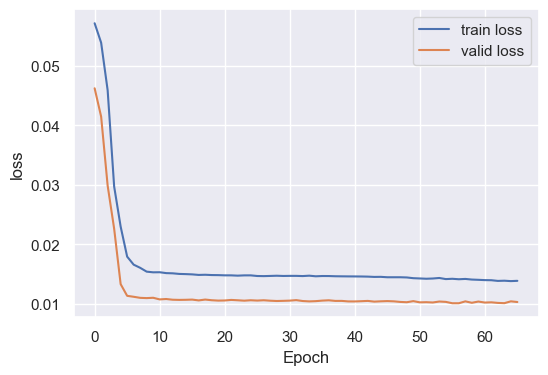

In [41]:
autoencoder = build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio)

history = train_autoencoder(autoencoder,X,batch,epoch,val,patience)

In [42]:
def reconstruction_loss(model,x_train,x_test):
    
    x_train_pred  = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    print('\n')
    plt.figure(figsize=(6,4))
    plt.title('Reconstruction MAE Loss')
    plt.hist(train_mae_loss, bins=40,color='blue',density=True,label='Train')
    plt.hist(test_mae_loss, bins=40,color='red',density=True,label='Test')
    plt.legend()
    plt.show()

    threshold_train = np.max(train_mae_loss) 
    threshold_test = np.max(test_mae_loss) 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    print("Test Reconstruction error threshold:", threshold_test)
    
    #anomalies = threshold_test > threshold_train
    #print('\n')
    #print("Train Threshold Based Detected Anomalies: ", np.sum(anomalies))
    #print("Real Normal Labels from Test Data : ", y_test.value_counts()[0])
    #print("Real Fault Labels from Test Data : ", y_test.value_counts()[1])
    
    return train_mae_loss, test_mae_loss, threshold_train, threshold_test

2/2 [==============================] - 0s 0s/step




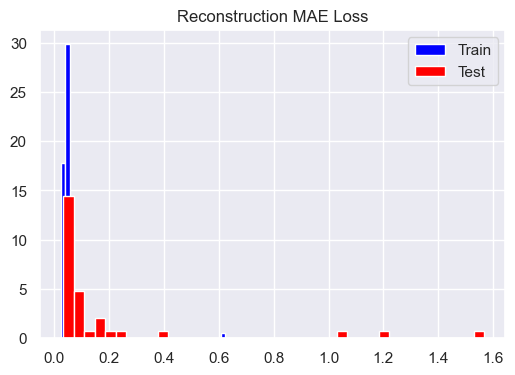



Train (Normal Only) Reconstruction error threshold: 0.6224340735706416


Test Reconstruction error threshold: 1.5669154685411109


In [43]:
train_mae_loss, test_mae_loss, threshold_train, threshold_test = reconstruction_loss(autoencoder,X_train_Normal,X_test)

In [44]:
def anomaly_threshold(threshold,model):
    test_score_df = pd.DataFrame(X_test[:])
    test_score_df['loss'] = test_mae_loss # --> pred_proba
    test_score_df['threshold'] = threshold # 레이블 예측 임계값 
    test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
    test_score_df['score'] = test_score_df["anomaly"].astype(int) # 예측 레이블 
    get_clf_eval(y_test,test_score_df['score'],test_score_df['loss'])
    print('\n')
    print(classification_report(y_test, test_score_df['score'],target_names=['양품','불량']))
    
    test_error = pd.DataFrame({'Reconstruction_error': test_mae_loss,'True_class': y_test.reset_index()['condition']})

    plt.figure(figsize=(4, 3))
    plt.title(model, fontsize=12)
    plt.scatter(test_error.index[test_error['True_class'] == 0],test_error[test_error['True_class'] == 0]['Reconstruction_error'], s = 10, label = 'Normal')
    plt.scatter(test_error.index[test_error['True_class'] == 1],test_error[test_error['True_class'] == 1]['Reconstruction_error'], s = 10, label = 'Fault')
    plt.xlabel('Count', fontsize=10)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=10)
    plt.axhline(threshold,color = 'red', ls = '--', label = 'Threshold = %0.2f' % (threshold))
    plt.legend(bbox_to_anchor=(1.0, 1.03))
    plt.show()

In [45]:
threshold_train

0.6224340735706416

Confusion Matrix
[[19  2]
 [ 9  8]]


정확도: 0.711 정밀도: 0.8 재현율: 0.471 AUC: 0.569 F1: 0.593 F2: 0.513 Balanced_Accuracy: 0.688


              precision    recall  f1-score   support

          양품       0.68      0.90      0.78        21
          불량       0.80      0.47      0.59        17

    accuracy                           0.71        38
   macro avg       0.74      0.69      0.68        38
weighted avg       0.73      0.71      0.69        38



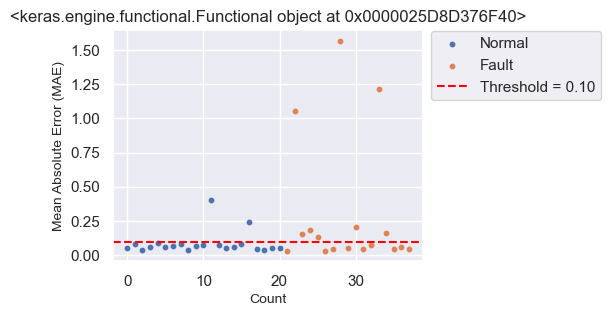

In [46]:
anomaly_threshold(threshold=0.1,model=autoencoder)

In [47]:
#for i in range(0,len(test_mae_loss)):
    
    
#    anomaly_threshold(test_mae_loss[i],'Autoencoder')
#    print('threshold'+ ' = ' + str(test_mae_loss[i]))
#    print('-----------------------------------------------------------------------------------------')
#    print('\n')